Reloading Tuner from HR_LSTM_Tuning\LSTM_Hyperparameter_Tuning\tuner0.json
Available metrics for this trial: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error']
Available metrics for this trial: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error']
Available metrics for this trial: ['loss', 'mean_absolute_error', 'mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error']
Available metrics for this trial: []
Available metrics for this trial: []

Hyperparameter Tuning Results:
        MSE       MAE
0  0.001105  0.023746
1  0.001006  0.022416
2  0.000618  0.018767
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step
Model Evaluation Metrics:
MSE: 0.3256
MAE: 0.3648


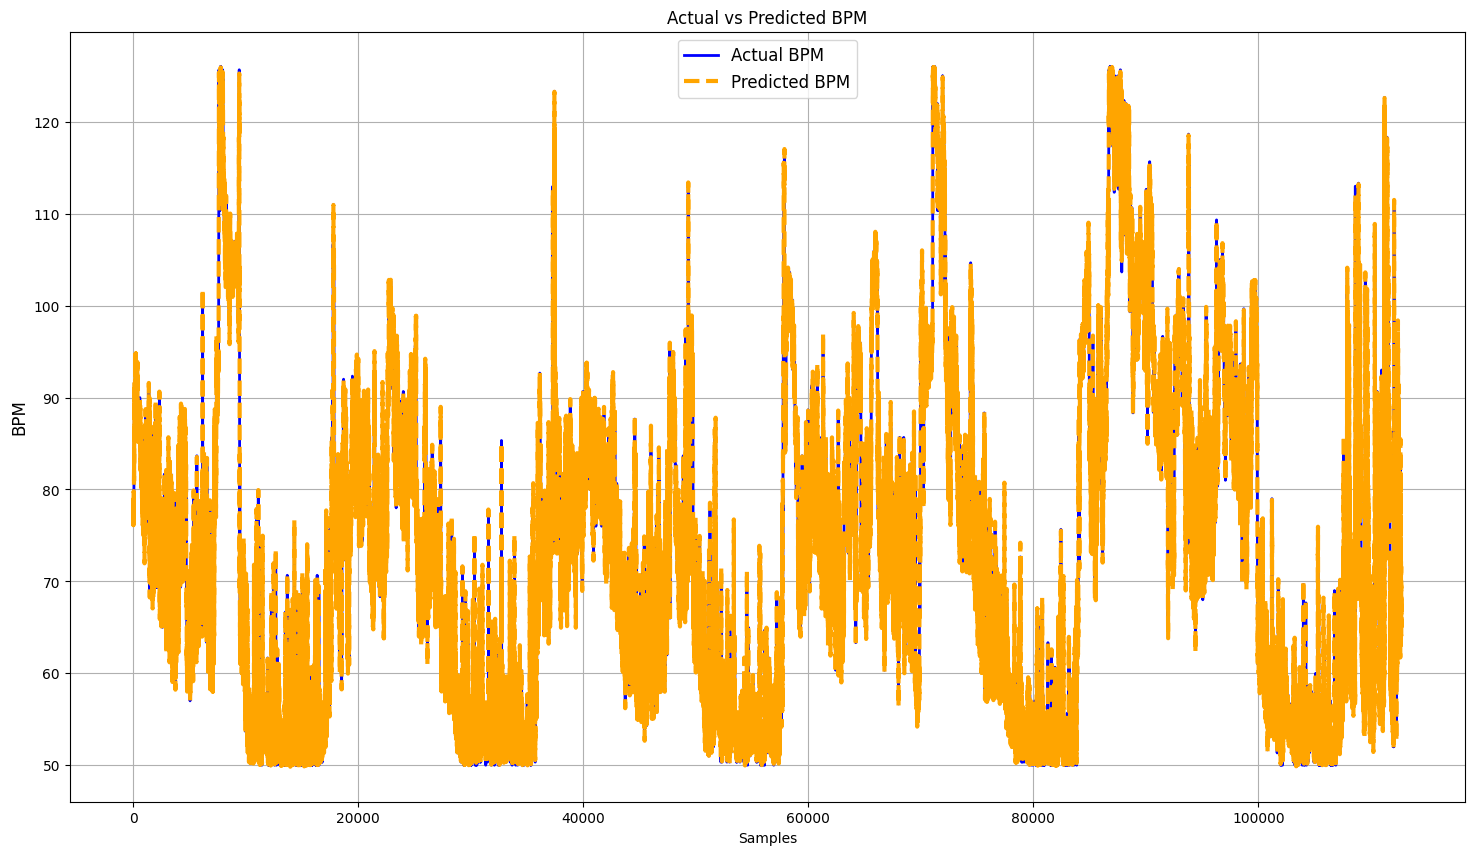

In [8]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from scipy import stats
from keras_tuner import RandomSearch
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Create the directory for tuning results if it doesn't exist
tuning_dir = "HR_LSTM_Tuning"
os.makedirs(tuning_dir, exist_ok=True)

class HeartRateModel:
    def __init__(self):
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(-1, 1))  # MinMaxScaler for normalization

    # Function to build the model with hyperparameters
    def build_model(self, hp, input_shape):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                       return_sequences=True, input_shape=input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

        model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

        model.add(Dense(1))
        # Compile the model with metrics that include 'mean_squared_error' and 'mean_absolute_error'
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error',
                      metrics=['mean_squared_error', 'mean_absolute_error'])
        return model

    # Function to train the model
    def train_model(self, X_train, y_train, epochs=15, batch_size=32):
        callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        history = self.model.fit(X_train, y_train,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_split=0.2,
                                 callbacks=callbacks)
        print("Model training completed.")
        return history

    # Function to evaluate the model
    def evaluate_model(self, X_test, y_test, scaler, num_samples=None):
        predictions = self.model.predict(X_test)

        # Inverse transform to get actual bpm values
        predictions = scaler.inverse_transform(predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate metrics
        mse = mean_squared_error(y_test_actual, predictions)
        mae = mean_absolute_error(y_test_actual, predictions)
        print(f"Model Evaluation Metrics:\nMSE: {mse:.4f}\nMAE: {mae:.4f}")

        # Determine the number of samples to plot
        if num_samples is None or num_samples > len(y_test_actual):
            num_samples = len(y_test_actual)

        # Plot Actual vs Predicted
        plt.figure(figsize=(18, 10))
        plt.plot(y_test_actual[:num_samples], label='Actual BPM', color='blue', linewidth=2)
        plt.plot(predictions[:num_samples], label='Predicted BPM', color='orange', linestyle='--', linewidth=3)
        plt.title('Actual vs Predicted BPM', fontsize=12)
        plt.xlabel('Samples', fontsize=10)
        plt.ylabel('BPM', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

    # Data Cleaning and Preprocessing Functions
    def load_data(self, csv_file_path):
        df = pd.read_csv(csv_file_path)

        # Combine date and time columns into dateTime
        df['dateTime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        return df

    def filter_by_bpm(self, df, bpm_threshold=50):
        df = df[df['bpm'] >= bpm_threshold].reset_index(drop=True)
        return df

    def sort_data(self, df):
        df = df.sort_values('dateTime').reset_index(drop=True)
        return df

    def remove_outliers(self, df, z_threshold=3):
        df['z_score'] = np.abs(stats.zscore(df['bpm']))
        df = df[df['z_score'] < z_threshold].reset_index(drop=True)
        df.drop('z_score', axis=1, inplace=True)
        return df

    def remove_noise(self, df, window_size=3):
        df['bpm'] = df['bpm'].rolling(window=window_size, center=True).mean()
        df['bpm'].fillna(method='bfill', inplace=True)
        df['bpm'].fillna(method='ffill', inplace=True)
        return df

    def normalize_bpm(self, df):
        df['bpm_normalized'] = self.scaler.fit_transform(df['bpm'].values.reshape(-1, 1))
        return df

    # Function to prepare LSTM data
    def prepare_lstm_data(self, df, sequence_length=10):
        data = df['bpm_normalized'].values

        X, y = [], []
        for i in range(sequence_length, len(data)):
            X.append(data[i-sequence_length:i])
            y.append(data[i])

        X, y = np.array(X), np.array(y)

        # Reshape X for LSTM [samples, time steps, features]
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        # Splitting data into training and testing sets
        split_index = int(len(X) * 0.8)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        return X_train, X_test, y_train, y_test

# Usage Example
if __name__ == "__main__":
    # Instantiate the model class
    hr_model = HeartRateModel()

    # Load, clean, and preprocess the data
    csv_path = 'E:\\chatbot-01\\datasets\\hr\\heart_rate_data.csv'
    df_cleaned = hr_model.load_data(csv_path)

    # Apply data cleaning steps
    df_cleaned = hr_model.filter_by_bpm(df_cleaned)
    df_cleaned = hr_model.sort_data(df_cleaned)
    df_cleaned = hr_model.remove_outliers(df_cleaned)
    df_cleaned = hr_model.remove_noise(df_cleaned)
    df_cleaned = hr_model.normalize_bpm(df_cleaned)  # Normalize bpm

    # Prepare the data for LSTM model
    X_train, X_test, y_train, y_test = hr_model.prepare_lstm_data(df_cleaned)

    # Perform RandomSearch for hyperparameter tuning with results saved in "HR_LSTM_Tuning"
    tuner = RandomSearch(
        lambda hp: hr_model.build_model(hp, input_shape=(X_train.shape[1], 1)),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory=tuning_dir,  # Specify the tuning directory
        project_name='LSTM_Hyperparameter_Tuning'
    )

    # Start the hyperparameter search
    tuner.search(
        X_train, y_train, epochs=15, validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
    )

    # Store evaluation metrics for each trial
    trials_results = []

    # Retrieve trial results and display them in a table
    for trial in tuner.oracle.get_best_trials(num_trials=5):
        available_metrics = list(trial.metrics.metrics.keys())
        print(f"Available metrics for this trial: {available_metrics}")
        
        mse = trial.metrics.get_last_value('mean_squared_error') if 'mean_squared_error' in available_metrics else None
        mae = trial.metrics.get_last_value('mean_absolute_error') if 'mean_absolute_error' in available_metrics else None

        if mse is not None and mae is not None:
            trials_results.append((mse, mae))

    trials_df = pd.DataFrame(trials_results, columns=['MSE', 'MAE'])
    print("\nHyperparameter Tuning Results:")
    print(trials_df)

    # Retrieve the best model
    hr_model.model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the best model
    hr_model.evaluate_model(X_test, y_test, hr_model.scaler)


Reloading Tuner from HR_LSTM_Tuning\LSTM_Hyperparameter_Tuning\tuner0.json
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step
Model Evaluation Metrics:
MSE: 0.3256
MAE: 0.3648


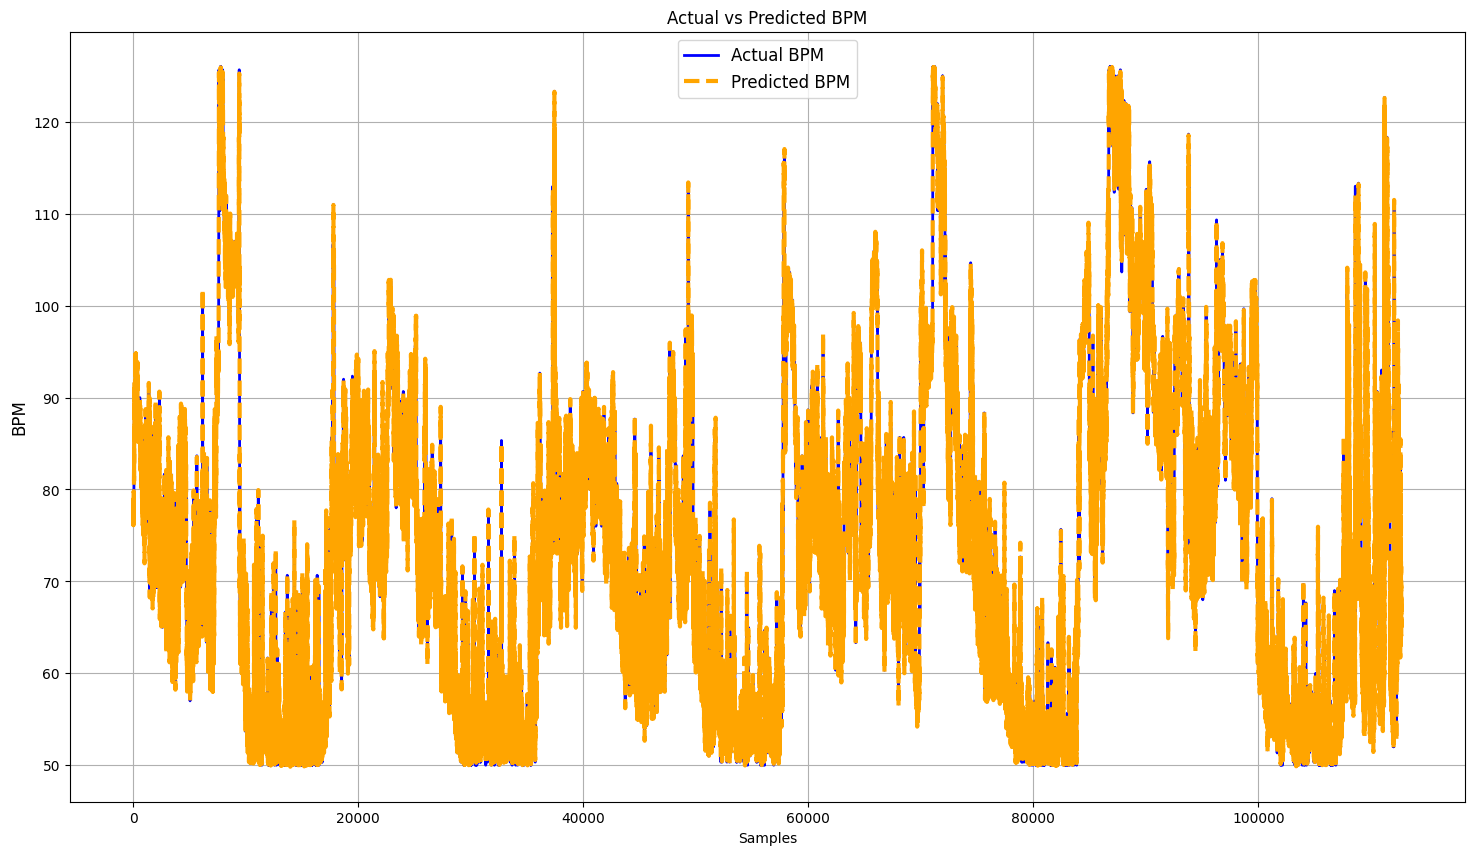

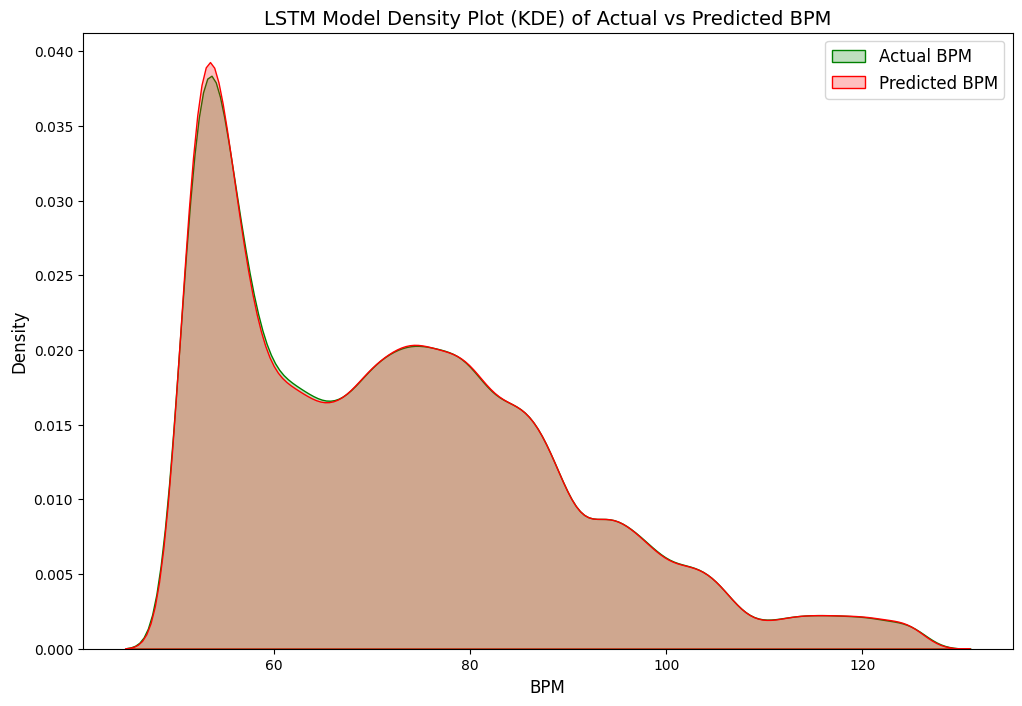

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from scipy import stats
from keras_tuner import RandomSearch
import os
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Create the directory for tuning results if it doesn't exist
tuning_dir = "HR_LSTM_Tuning"
os.makedirs(tuning_dir, exist_ok=True)

class HeartRateModel:
    def __init__(self):
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(-1, 1))  # MinMaxScaler for normalization

    # Function to build the model with hyperparameters
    def build_model(self, hp, input_shape):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units_1', min_value=32, max_value=256, step=32),
                       return_sequences=True, input_shape=input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

        model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=256, step=32)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

        model.add(Dense(1))
        # Compile the model with metrics that include 'mean_squared_error' and 'mean_absolute_error'
        model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                      loss='mean_squared_error',
                      metrics=['mean_squared_error', 'mean_absolute_error'])
        return model

    # Function to train the model
    def train_model(self, X_train, y_train, epochs=15, batch_size=32):
        callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        history = self.model.fit(X_train, y_train,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_split=0.2,
                                 callbacks=callbacks)
        print("Model training completed.")
        return history

    # Function to evaluate the model with KDE Plot
    def evaluate_model(self, X_test, y_test, scaler, num_samples=None):
        predictions = self.model.predict(X_test)

        # Inverse transform to get actual bpm values
        predictions = scaler.inverse_transform(predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate metrics
        mse = mean_squared_error(y_test_actual, predictions)
        mae = mean_absolute_error(y_test_actual, predictions)
        print(f"Model Evaluation Metrics:\nMSE: {mse:.4f}\nMAE: {mae:.4f}")

        # Determine the number of samples to plot
        if num_samples is None or num_samples > len(y_test_actual):
            num_samples = len(y_test_actual)

        # Plot Actual vs Predicted
        plt.figure(figsize=(18, 10))
        plt.plot(y_test_actual[:num_samples], label='Actual BPM', color='blue', linewidth=2)
        plt.plot(predictions[:num_samples], label='Predicted BPM', color='orange', linestyle='--', linewidth=3)
        plt.title('Actual vs Predicted BPM', fontsize=12)
        plt.xlabel('Samples', fontsize=10)
        plt.ylabel('BPM', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.show()

        # Plot: KDE Plot for Actual vs Predicted BPM
        plt.figure(figsize=(12, 8))
        sns.kdeplot(y_test_actual[:num_samples].flatten(), label='Actual BPM', color='green', fill=True)
        sns.kdeplot(predictions[:num_samples].flatten(), label='Predicted BPM', color='red', fill=True)
        plt.title('LSTM Model Density Plot (KDE) of Actual vs Predicted BPM', fontsize=14)
        plt.xlabel('BPM', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(False)
        plt.show()

    # Data Cleaning and Preprocessing Functions
    def load_data(self, csv_file_path):
        df = pd.read_csv(csv_file_path)

        # Combine date and time columns into dateTime
        df['dateTime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

        return df

    def filter_by_bpm(self, df, bpm_threshold=50):
        df = df[df['bpm'] >= bpm_threshold].reset_index(drop=True)
        return df

    def sort_data(self, df):
        df = df.sort_values('dateTime').reset_index(drop=True)
        return df

    def remove_outliers(self, df, z_threshold=3):
        df['z_score'] = np.abs(stats.zscore(df['bpm']))
        df = df[df['z_score'] < z_threshold].reset_index(drop=True)
        df.drop('z_score', axis=1, inplace=True)
        return df

    def remove_noise(self, df, window_size=3):
        df['bpm'] = df['bpm'].rolling(window=window_size, center=True).mean()
        df['bpm'].fillna(method='bfill', inplace=True)
        df['bpm'].fillna(method='ffill', inplace=True)
        return df

    def normalize_bpm(self, df):
        df['bpm_normalized'] = self.scaler.fit_transform(df['bpm'].values.reshape(-1, 1))
        return df

    # Function to prepare LSTM data
    def prepare_lstm_data(self, df, sequence_length=10):
        data = df['bpm_normalized'].values

        X, y = [], []
        for i in range(sequence_length, len(data)):
            X.append(data[i-sequence_length:i])
            y.append(data[i])

        X, y = np.array(X), np.array(y)

        # Reshape X for LSTM [samples, time steps, features]
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        # Splitting data into training and testing sets
        split_index = int(len(X) * 0.8)
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        return X_train, X_test, y_train, y_test

# Usage Example
if __name__ == "__main__":
    # Instantiate the model class
    hr_model = HeartRateModel()

    # Load, clean, and preprocess the data
    csv_path = 'E:\\chatbot-01\\datasets\\hr\\heart_rate_data.csv'
    df_cleaned = hr_model.load_data(csv_path)

    # Apply data cleaning steps
    df_cleaned = hr_model.filter_by_bpm(df_cleaned)
    df_cleaned = hr_model.sort_data(df_cleaned)
    df_cleaned = hr_model.remove_outliers(df_cleaned)
    df_cleaned = hr_model.remove_noise(df_cleaned)
    df_cleaned = hr_model.normalize_bpm(df_cleaned)  # Normalize bpm

    # Prepare the data for LSTM model
    X_train, X_test, y_train, y_test = hr_model.prepare_lstm_data(df_cleaned)

    # Perform RandomSearch for hyperparameter tuning with results saved in "HR_LSTM_Tuning"
    tuner = RandomSearch(
        lambda hp: hr_model.build_model(hp, input_shape=(X_train.shape[1], 1)),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory=tuning_dir,  # Specify the tuning directory
        project_name='LSTM_Hyperparameter_Tuning'
    )

    # Start the hyperparameter search
    tuner.search(
        X_train, y_train, epochs=15, validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
    )

    # Retrieve the best model
    hr_model.model = tuner.get_best_models(num_models=1)[0]

    # Evaluate the best model
    hr_model.evaluate_model(X_test, y_test, hr_model.scaler)
